<a href="https://colab.research.google.com/github/narma-17/International-football-results-from-1872-to-2021/blob/main/Qatar_2022_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Qatar World Cup 2022**

In this work book, we pickup from where we left with the work on football match data from https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017. Here will try to make prediction about a team's success in the Qatar 2022 FIFA World Cup.

## **a) Defining a ML algorithm to find the team that would be most successful (highest number of wins) in the 2022 FIFA tournament.**

Predicting the most sucessful team from the data set we have been working with which gives data on past matches, wins and locations maybe difficult for two reasons.
1. The proficiency of a team changes over time. A team that was previously successful may not be successful now. 
2. Is is mostly in FIFA matches that countries around the world face off against each other. In most friendly matches and other regional tournaments, teams face off against regional peers. This means that even if a team is very successful in the regional matches and friendly matches, if it was, say, an Asian country, it might not be very successful against the European countries that it would face in FIFA. Taking only previous FIFA matches would also not make sense since that would be related to data that was four years in the past and thus may not apply now as the team strength may have changed.

To circumvent the issue, we have taken the player level data from the EA sports FIFA data set, and thus will be aiming to predict team performance based on the strength of the potential players for the team and possibly current ranking of the team. The datasets can be obtained at https://www.kaggle.com/bryanb/fifa-player-stats-database?select=FIFA17_official_data.csv.

The original web hosted dataset can be obtained by scraping data from https://sofifa.com/

The approach that has been taken to the problem is 
1. To build a dataset about the team's performance levels as of 2017, and other variables such as their FIFA rank 
2. Train the model on the results from the 2018 World Cup
3. Use the model to predict the performance of teams in the 2022 cup considering their skills level as of early 2021.

**Initiating Google Drive on Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -s /content/drive/My\ Drive/UoM\ Working\ Folders/Football/ /wd

**Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

#### **Loading the EA Sports player dataset for 2017 and 2021**

In [ ]:
df21=pd.read_csv('/wd/FIFA21_official_data.csv')
df21.sample()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness
14726,252370,N. Silva,21,https://cdn.sofifa.com/players/252/370/20_60.png,Chile,https://cdn.sofifa.com/flags/cl.png,55,62,CD Huachipato,https://cdn.sofifa.com/teams/111327/light_30.png,€120K,€1K,1362,Right,1.0,3.0,2.0,Medium/ Medium,Lean (170-),No,"<span class=""pos pos28"">SUB",22.0,"Jul 1, 2019",NaN,2022,5'6,146lbs,30.0,56.0,57.0,45.0,44.0,56.0,36.0,33.0,34.0,53.0,63.0,58.0,56.0,56.0,71.0,54.0,62.0,55.0,60.0,55.0,30.0,18.0,54.0,54.0,62.0,50.0,NaN,24.0,22.0,11.0,8.0,10.0,12.0,7.0,ST,57.0,€186K,16.0
6197,239258,E. Banda,22,https://cdn.sofifa.com/players/239/258/20_60.png,Zambia,https://cdn.sofifa.com/flags/zm.png,62,69,Djurgårdens IF,https://cdn.sofifa.com/teams/710/light_30.png,€425K,€1K,1738,Left,1.0,3.0,3.0,High/ Medium,Lean (170-185),No,"<span class=""pos pos28"">SUB",22.0,"Feb 22, 2020",NaN,2022,5'10,161lbs,64.0,53.0,46.0,63.0,68.0,62.0,65.0,65.0,62.0,63.0,76.0,60.0,71.0,63.0,73.0,73.0,87.0,58.0,59.0,60.0,41.0,43.0,52.0,64.0,48.0,59.0,NaN,56.0,51.0,13.0,11.0,6.0,7.0,14.0,CAM,64.0,€616K,41.0
13784,256501,E. Roldán,19,https://cdn.sofifa.com/players/256/501/20_60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,57,68,Boca Juniors,https://cdn.sofifa.com/teams/1877/light_30.png,€170K,€2K,1431,Right,1.0,2.0,2.0,Medium/ Medium,Normal (170-185),No,"<span class=""pos pos29"">RES",26.0,"Feb 28, 2020",NaN,2023,5'9,154lbs,52.0,58.0,44.0,48.0,52.0,63.0,46.0,44.0,45.0,60.0,73.0,68.0,60.0,40.0,72.0,60.0,51.0,48.0,60.0,46.0,27.0,28.0,52.0,51.0,53.0,44.0,NaN,30.0,29.0,7.0,6.0,8.0,6.0,13.0,RM,58.0,€272K,31.0
2479,202620,R. Boateng,27,https://cdn.sofifa.com/players/202/620/20_60.png,Ghana,https://cdn.sofifa.com/flags/gh.png,70,70,AD Alcorcón,https://cdn.sofifa.com/teams/100831/light_30.png,€1.8M,€6K,1891,Right,1.0,2.0,3.0,Medium/ Medium,Lean (170-185),No,"<span class=""pos pos18"">CAM",7.0,"Jul 15, 2019",NaN,2021,5'10,146lbs,52.0,69.0,65.0,72.0,40.0,68.0,47.0,45.0,71.0,70.0,68.0,72.0,67.0,64.0,71.0,72.0,80.0,79.0,74.0,73.0,72.0,66.0,70.0,67.0,46.0,62.0,NaN,70.0,66.0,8.0,12.0,15.0,6.0,10.0,CM,70.0,€2.8M,64.0
9129,212204,B. Mechele,27,https://cdn.sofifa.com/players/212/204/20_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,76,78,Club Brugge KV,https://cdn.sofifa.com/teams/231/light_30.png,€8M,€22K,1632,Right,1.0,4.0,2.0,Medium/ High,Normal (185+),No,"<span class=""pos pos4"">RCB",44.0,"Nov 1, 2012",NaN,2023,6'3,174lbs,47.0,33.0,76.0,57.0,27.0,53.0,30.0,33.0,54.0,63.0,58.0,66.0,59.0,67.0,55.0,56.0,65.0,77.0,78.0,24.0,75.0,82.0,30.0,34.0,35.0,73.0,NaN,81.0,79.0,11.0,7.0,13.0,13.0,12.0,CB,78.0,€11.8M,82.0


In [ ]:
df21.columns

In [ ]:
df17=pd.read_csv('/wd/FIFA17_official_data.csv')
df17.sample(5)

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating
1452,190093,Dani Castellano,28,https://cdn.sofifa.com/players/190/093/17_60.png,Spain,https://cdn.sofifa.com/flags/es.png,75,75,UD Las Palmas,https://cdn.sofifa.com/teams/472/light_30.png,€3.1M,€20K,1927,Left,1.0,3.0,2.0,High/ Medium,Normal (170-185),No,"<span class=""pos pos7"">LB",23.0,"Jan 1, 2011",NaN,2020,5'11,152lbs,77.0,46.0,60.0,74.0,45.0,75.0,67.0,47.0,62.0,73.0,78.0,77.0,72.0,72.0,76.0,60.0,73.0,86.0,77.0,53.0,67.0,68.0,63.0,62.0,48.0,64.0,68.0,73.0,75.0,6.0,7.0,15.0,14.0,11.0,LWB,75.0
15663,212948,F. Ondoa,20,https://cdn.sofifa.com/players/212/948/17_60.png,Cameroon,https://cdn.sofifa.com/flags/cm.png,66,78,Sevilla Atlético,https://cdn.sofifa.com/teams/110714/light_30.png,€1M,€2K,1206,Right,1.0,2.0,1.0,Medium/ Medium,Normal (185+),No,"<span class=""pos pos28"">SUB",25.0,NaN,"<a href=""/team/15019/gimnastic-de-tarragona/"">...","Jun 30, 2017",6'1,192lbs,14.0,18.0,16.0,41.0,21.0,16.0,13.0,20.0,45.0,22.0,50.0,56.0,67.0,59.0,52.0,16.0,72.0,43.0,74.0,16.0,19.0,16.0,12.0,30.0,23.0,27.0,20.0,15.0,15.0,75.0,59.0,62.0,63.0,66.0,GK,65.0
16054,226721,G. Alcalá,23,https://cdn.sofifa.com/players/226/721/17_60.png,Mexico,https://cdn.sofifa.com/flags/mx.png,60,66,Querétaro,https://cdn.sofifa.com/teams/110150/light_30.png,€220K,€2K,1138,Right,1.0,2.0,1.0,Medium/ Medium,Normal (170-185),No,"<span class=""pos pos28"">SUB",33.0,"Jan 1, 2015",NaN,2023,5'10,161lbs,18.0,17.0,18.0,24.0,16.0,13.0,13.0,17.0,22.0,19.0,59.0,61.0,56.0,58.0,66.0,22.0,65.0,42.0,64.0,21.0,22.0,11.0,12.0,35.0,21.0,31.0,21.0,12.0,19.0,65.0,54.0,55.0,56.0,64.0,GK,59.0
10693,177643,M. Diakité,29,https://cdn.sofifa.com/players/177/643/17_60.png,France,https://cdn.sofifa.com/flags/fr.png,71,71,Ternana,https://cdn.sofifa.com/teams/570/light_30.png,€1.2M,€3K,1564,Right,1.0,3.0,2.0,Medium/ High,Stocky (185+),No,"<span class=""pos pos28"">SUB",33.0,"Jan 16, 2017",NaN,2020,6'4,194lbs,41.0,21.0,71.0,51.0,32.0,41.0,31.0,31.0,56.0,51.0,64.0,71.0,33.0,66.0,33.0,76.0,86.0,53.0,90.0,51.0,73.0,69.0,39.0,35.0,41.0,68.0,69.0,68.0,69.0,11.0,7.0,8.0,13.0,13.0,CB,70.0
3720,198033,Alex,24,https://cdn.sofifa.com/players/198/033/17_60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,72,73,Moreirense FC,https://cdn.sofifa.com/teams/1900/light_30.png,€2.5M,€7K,1811,Left,1.0,3.0,4.0,High/ Medium,Lean (170-185),No,"<span class=""pos pos28"">SUB",10.0,NaN,"<a href=""/team/1887/vitoria-guimaraes/"">Vitóri...","Jun 30, 2017",5'9,150lbs,71.0,65.0,52.0,71.0,62.0,74.0,76.0,71.0,61.0,73.0,78.0,77.0,85.0,72.0,78.0,72.0,56.0,68.0,46.0,71.0,50.0,23.0,70.0,70.0,68.0,70.0,35.0,28.0,31.0,6.0,14.0,12.0,11.0,14.0,CAM,72.0


In [ ]:
print(df21.shape)
print(df17.shape)

(17108, 65)
(17560, 63)


#### **Narrowing down the Countries**

Since most countries do not qualify for FIFA and our concern is with the countries that win n themost matches in the tournament itself, we will be screening out the top performing companies. The top 50 companies as per the FIFA ranking has been taken.

In [ ]:
Top50_2017=['Brazil','Germany','Argentina','Switzerland','Poland','Portugal','Chile','Colombia','Belgium','France','Spain','Italy','England','Mexico',
            'Peru','Croatia','Uruguay','Wales','Sweden','Iceland','Costa Rica','Slovakia','Northern Ireland','Iran','Egypt','United States','Ukraine','DR Congo',
            'Republic of Ireland','Bosnia Herzegovina','Senegal','Ecuador','Turkey','Tunisia','Cameroon','Netherlands','Austria','Greece','Nigeria',
            'Czech Republic','Paraguay','Serbia','Romania','Japan','Australia','Denmark','Burkina Faso','Algeria','Korea Republic','Ghana','Russia']

Top50_2021=['Belgium','Brazil','France','England','Italy','Argentina','Spain','Portugal','Mexico','United States','Denmark','Netherlands','Uruguay',
            'Switzerland','Colombia','Germany','Sweden','Croatia','Wales','Chile','Senegal','Peru','Austria','Japan','Ukraine','Iran','Poland',
            'Tunisia','Serbia','Algeria','Czech Republic','Morocco','Paraguay','Nigeria','Australia','Korea Republic','Hungary','Slovakia','Turkey','Venezuela',
            'Russia','Qatar','Norway','Costa Rica','Romania','Egypt','Republic of Ireland','Greece','Scotland','Jamaica']

In [ ]:
df21=df21.loc[df21['Nationality'].isin(Top50_2021)]
df17=df17.loc[df17['Nationality'].isin(Top50_2017)]

In [ ]:
print(df21.shape)
print(df17.shape)

(14824, 65)
(15185, 63)


#### **Screening out currently active players**

Since the data set includes some once famous players who have retired since, we will need to screen them out. We will be doing a screen based on whether the player has a active contract with a football club. For some players, the contract expiry date is missing, and for others the contract expires this year. A rough check on a sample of this players shows that those who are on average more than 35 years have retired while those who are less are active. 


In [ ]:
df21['Contract Valid Until'].unique()

array(['2022', '2023', '2025', '2024', '2021', '2026', 'Jun 30, 2021',
       '2013', '2019', nan, '2012', '2020', '2017', '2018', '2016',
       '2011', 'May 31, 2021', '2014', 'Dec 31, 2020', 'Jun 30, 2020',
       '2015', '2028', 'Jun 30, 2018', 'Jun 30, 2019', 'May 31, 2020',
       'Jan 30, 2021', 'Dec 31, 2021', 'May 31, 2018', 'Jun 30, 2014',
       'Jun 30, 2022', 'Jul 5, 2021', 'May 31, 2019', 'Jan 31, 2021',
       'Jun 30, 2017', 'May 25, 2016', 'Aug 31, 2020', 'Jul 1, 2021',
       'Jan 1, 2021', 'Jan 17, 2021', 'Dec 31, 2014', 'Jun 23, 2021',
       'Dec 31, 2017', '2009', 'Jun 1, 2021', 'Jan 3, 2021', '2007',
       'Nov 27, 2021', 'Nov 30, 2020', '2010', 'May 31, 2022', '2008',
       'Dec 30, 2020', 'Jun 30, 2015', 'Jan 4, 2021', 'Dec 31, 2019',
       'May 31, 2016', 'Jan 1, 2020', 'Dec 30, 2021', 'Jun 30, 2016'],
      dtype=object)

The column should ideally include only the year, thus we will clean the column to extract the year

In [ ]:
def year_extract(x):
  if isinstance(x, list):
    if len(x)==0:
      return np.nan
    else:
      return x[0]
  else:
    return np.nan

df21['Contract Valid Until year']=df21['Contract Valid Until'].str.findall(r'[0-9]{4}').apply(lambda x:year_extract(x))
df17['Contract Valid Until year']=df17['Contract Valid Until'].str.findall(r'[0-9]{4}').apply(lambda x:year_extract(x))

In [ ]:
df21['Contract Valid Until year'].unique()

array(['2022', '2023', '2025', '2024', '2021', '2026', '2013', '2019',
       nan, '2012', '2020', '2017', '2018', '2016', '2011', '2014',
       '2015', '2028', '2009', '2007', '2010', '2008'], dtype=object)

In [ ]:
print(df21['Contract Valid Until year'].isna().sum())
print(df17['Contract Valid Until year'].isna().sum())

268
204


In [ ]:
df17[df17['Contract Valid Until year'].isna()].to_csv(r'/wd/missing_contract1.csv')

In [ ]:
df21.loc[((df21['Contract Valid Until year'].isna())|(df21['Contract Valid Until year']=='2021'))& (df21['Age']<35),'Contract Valid Until year']='2021'
df21.loc[((df21['Contract Valid Until year'].isna())|(df21['Contract Valid Until year']=='2021'))& (df21['Age']>=35),'Contract Valid Until year']='2020'

In [ ]:
df21['Contract Valid Until year'].isna().sum()

0

In [ ]:
df17.loc[((df17['Contract Valid Until year'].isna())|(df17['Contract Valid Until year']=='2021'))& (df17['Age']<35),'Contract Valid Until year']='2017'
df17.loc[((df17['Contract Valid Until year'].isna())|(df17['Contract Valid Until year']=='2021'))& (df17['Age']>=35),'Contract Valid Until year']='2016'

In [ ]:
df21['Contract Valid Until year']=df21['Contract Valid Until year'].astype('int')
df17['Contract Valid Until year']=df17['Contract Valid Until year'].astype('int')

In [ ]:
# Removing players who were likely retired at that time
df21=df21.loc[df21['Contract Valid Until year']>=2021]
df17=df17.loc[df17['Contract Valid Until year']>=2017]
print(df21.shape)
print(df17.shape)

(12470, 66)
(15136, 64)


#### **Narrowing down columns**

Since, once we finish designing the dataset for our prediction we will only have 50 rows, we cannot have too many independent variables. Summarizing all the details in a meaningful way considering the players position requires a deep knowledge of football. Fortunately EA Sports also gives a overall score which computes the overall score as a weighted average of skills where weight are decided based on the players position. More details about the scoring system can be obtained from https://www.goal.com/en-ae/news/fifa-player-ratings-explained-how-are-the-card-number-stats/1hszd2fgr7wgf1n2b2yjdpgynu.

We have also considered penalties, since from the Top 16 onwards, many teams draw and the team that goes forward is decided by penalty shots. Since the more matches a team plays, the greater the possible number of wins, penalties might be a relevant variable.

In [ ]:
#Select columns to keep, based on relevance and presence in both datasets
columns=['Name','Nationality', 'Overall','Best Position','Penalties']

df17=df17[columns]
df21=df21[columns]

#### **Summarizing positions as attack, defense and midfield**

In [ ]:
df17['Best Position'].unique()

array(['ST', 'CDM', 'LB', 'CAM', 'RB', 'LWB', 'CM', 'RWB', 'RM', 'LM',
       'CB', 'LW', 'CF', 'RW', 'GK'], dtype=object)

- ST: Striker (Attack)
- LW: Left Wing (Attcack)
- CF: Center Forward (Attack)
- RW: Right Wing (Attack)
- CDM: Central Defensive Midfielder ( Midfielder)
- CAM: Central Advance Midfielder (Midfield)
- CM: Center Midfielder (Midfield)
- RM: Right Midfielder (Midfield
- LM: Left Midfielder (Midfield)
- CB: Center Back (Defense)
- LB: Left Back (Defense)
- RB: Right Back (Defense)
- LWB: Left Wing Back (Defense)
- RWB: Right Wing Back (Defense)

- GK: Goal Keeper

Since the positions vary based on formations, positions are to be grouped into attack, center, defense as they are traditionally grouped in football. 

In [ ]:
MDF=['LM','RM','CM','CAM','CDM'] # Midfield
ATK=['CF','RW','LW','ST'] #Attack
DFS=['CB','RWB','LWB','RB','LB'] # Defense

2021

In [ ]:
conditions_21=[df21['Best Position'].eq('LM')|df21['Best Position'].eq('RM')|df21['Best Position'].eq('CM')|df21['Best Position'].eq('CAM')|df21['Best Position'].eq('CDM'),
            df21['Best Position'].eq('CF')|df21['Best Position'].eq('RW')|df21['Best Position'].eq('LW')|df21['Best Position'].eq('ST'),
            df21['Best Position'].eq('CB')|df21['Best Position'].eq('RWB')|df21['Best Position'].eq('LWB')|df21['Best Position'].eq('RB')|df21['Best Position'].eq('LB'),
            df21['Best Position'].eq('GK')]

choices =['Midfield','Attack','Defense','GoalKeeper']

df21['Broad Position']=np.select(conditions_21,choices)
df21.head()

,Name,Nationality,Overall,Best Position,Penalties,Broad Position
0,L. Suárez,Uruguay,87,ST,83.0,Attack
1,K. De Bruyne,Belgium,91,CAM,84.0,Midfield
2,Bruno Fernandes,Portugal,87,CAM,91.0,Midfield
3,A. Griezmann,France,87,ST,86.0,Attack
4,M. Acuña,Argentina,83,LB,76.0,Defense


2017

In [ ]:
conditions_17=[df17['Best Position'].eq('LM')|df17['Best Position'].eq('RM')|df17['Best Position'].eq('CM')|df17['Best Position'].eq('CAM')|df17['Best Position'].eq('CDM'),
            df17['Best Position'].eq('CF')|df17['Best Position'].eq('RW')|df17['Best Position'].eq('LW')|df17['Best Position'].eq('ST'),
            df17['Best Position'].eq('CB')|df17['Best Position'].eq('RWB')|df17['Best Position'].eq('LWB')|df17['Best Position'].eq('RB')|df17['Best Position'].eq('LB'),
            df17['Best Position'].eq('GK')]

choices =['Midfield','Attack','Defense','GoalKeeper']

df17['Broad Position']=np.select(conditions_17,choices)
df17.head()

,Name,Nationality,Overall,Best Position,Penalties,Broad Position
0,L. Suárez,Uruguay,92,ST,85.0,Attack
1,R. Nainggolan,Belgium,86,CDM,63.0,Midfield
2,A. Vidal,Chile,87,CDM,84.0,Midfield
3,D. Alaba,Austria,86,LB,80.0,Defense
4,P. Pogba,France,88,CAM,76.0,Midfield


## **Creating a Countrywise Dataset**

#### **Aggregating player skill levels to national skill level**

The EA sports dataset gives player level data. However we require information on the performance of the team. Thus the player level data must be aggregated to a national level.

To do this, we will be identifying the nationality of players, selecting the top players from them (6 each of attack, midfield and defense players and 3 goalkeepers). The national teams skill level is approximated as the average of these top plyers of each country.

2017

In [ ]:
df_17_country=pd.DataFrame(columns=['Country','Attack','Midfield','Defense','Penalties','GoalKeeper'])

In [ ]:
areas =['Midfield','Attack','Defense','GoalKeeper']
for country in Top50_2017:
  country_df=df17.loc[df17['Nationality']==country]
  position_data={}
  position_data['Country']=country
  penalty_sum=0
  player_count=0
  for position in areas:
    position_df=country_df.loc[country_df['Broad Position']== position]
    position_df.sort_values(by='Overall',ascending=False,inplace=True)
    if position=='GoalKeeper':
      position_df=position_df.head(6)
    else:
      position_df=position_df.head(3) 
    if (position=='Attack')|(position=='Midfield'):
      penalty_sum+=position_df['Penalties'].sum()
      player_count+=position_df.shape[0]
    position_data[position]=position_df['Overall'].mean()
  position_data['Penalties']=penalty_sum/player_count
  df_17_country=df_17_country.append(position_data,ignore_index=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Filling missing values with the row average
df_17_country=df_17_country.T.fillna(df_17_country.mean(axis=1)).T

In [ ]:
df_17_country.tail(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper
46,Burkina Faso,69,76.3333,72,62,69.8333
47,Algeria,76.3333,82,76.6667,75.3333,66.5
48,Korea Republic,72.3333,76.6667,74.3333,70,72.5
49,Ghana,76.6667,78.6667,75.6667,64,61.5
50,Russia,78,80.3333,80,72.3333,78


2021

In [ ]:
df_21_country=pd.DataFrame(columns=['Country','Attack','Midfield','Defense','Penalties','GoalKeeper'])

In [ ]:
areas =['Midfield','Attack','Defense','GoalKeeper']
for country in Top50_2021:
  country_df=df21.loc[df21['Nationality']==country]
  position_data={}
  position_data['Country']=country
  penalty_sum=0
  player_count=0
  for position in areas:
    position_df=country_df.loc[country_df['Broad Position']== position]
    position_df.sort_values(by='Overall',ascending=False,inplace=True)
    if position=='GoalKeeper':
      position_df=position_df.head(3)
    else:
      position_df=position_df.head(6) 
    if (position=='Attack')|(position=='Midfield'):
      penalty_sum+=position_df['Penalties'].sum()
      player_count+=position_df.shape[0]
    position_data[position]=position_df['Overall'].mean()
  position_data['Penalties']=penalty_sum/player_count
  df_21_country=df_21_country.append(position_data,ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# Filling missing values with the row average
df_21_country=df_21_country.T.fillna(df_21_country.mean(axis=1)).T

In [ ]:
df_21_country.tail(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper
45,Egypt,73.6667,74,71.1667,70,71.6667
46,Republic of Ireland,73.3333,74.3333,78.1667,66.75,70.3333
47,Greece,71.3333,74.6667,77.5,61.75,77.3333
48,Scotland,71.3333,77.5,76.5,67,70.6667
49,Jamaica,69.1667,67.1667,68,62.4167,66.6875


#### **FIFA Ranks**

Since the FIFA also ranks national teams considering a variety of factors, the FIFA ranking as of August of the year prior to the World Cup has also been added as a variable.

In [ ]:
rank_17=pd.read_csv('/wd/Top50Rank2017.csv')
rank_17.columns=['index','Country','Rank']
rank_21=pd.read_csv('/wd/Top50Rank2021.csv')
rank_21.columns=['index','Country','Rank']

rank_17=rank_17.drop('index', axis=1)
rank_21=rank_21.drop('index', axis=1)

change_names={'IR Iran': 'Iran','USA':'United States','Congo DR':'DR Congo','Bosnia and Herzegovina':'Bosnia Herzegovina'}

rank_17['Country']=rank_17['Country'].replace(change_names)
rank_21['Country']=rank_21['Country'].replace(change_names)

df_17_country=pd.merge(df_17_country,rank_17,how='left',on='Country')
df_21_country=pd.merge(df_21_country,rank_21,how='left',on='Country')

## **Model For 2018 World Cup Final**

As mentioned below, the model will be trained on the results of the 2018 world cup and then applied to predict for 2022.

#### **Getting the dependent variable: Number of wins in the FIFA tournament**

We will get the number of wins of each country from the results dataset.

In [ ]:
df_results=pd.read_csv('/wd/results.csv')
df_results['date']=pd.to_datetime(df_results['date'])

In [ ]:
df_results['year']=pd.DatetimeIndex(df_results['date']).year
df_results_FIFA18=df_results.loc[(df_results['year']==2018) & (df_results['tournament']=='FIFA World Cup')]

In [ ]:
df_results_FIFA18.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
39913,2018-06-16,Croatia,Nigeria,2,0,FIFA World Cup,Kaliningrad,Russia,True,2018
39927,2018-06-21,France,Peru,1,0,FIFA World Cup,Ekaterinburg,Russia,True,2018
39961,2018-07-03,Colombia,England,1,1,FIFA World Cup,Moscow,Russia,True,2018
39922,2018-06-19,Russia,Egypt,3,1,FIFA World Cup,St. Petersburg,Russia,False,2018
39911,2018-06-16,Argentina,Iceland,1,1,FIFA World Cup,Moscow,Russia,True,2018


In [ ]:
winner=[]
for i in range(df_results_FIFA18.shape[0]):
  row=df_results_FIFA18.iloc[i]
  if row['home_score']>row['away_score']:
    winner.append(df_results_FIFA18.iloc[i]['home_team'])
  elif row['home_score']<row['away_score']:
    winner.append(df_results_FIFA18.iloc[i]['away_team'])
  else:
    winner.append('draw')

In [ ]:
df_results_FIFA18['winning country']=winner
df_results_FIFA18.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,winning country
39933,2018-06-23,South Korea,Mexico,1,2,FIFA World Cup,Rostov-on-Don,Russia,True,2018,Mexico
39970,2018-07-15,France,Croatia,4,2,FIFA World Cup,Moscow,Russia,True,2018,France
39945,2018-06-26,Iceland,Croatia,1,2,FIFA World Cup,Rostov-on-Don,Russia,True,2018,Croatia
39924,2018-06-20,Uruguay,Saudi Arabia,1,0,FIFA World Cup,Rostov-on-Don,Russia,True,2018,Uruguay
39919,2018-06-18,Tunisia,England,1,2,FIFA World Cup,Volgograd,Russia,True,2018,England


In [ ]:
winCountDf=df_results_FIFA18[['winning country','date']].groupby('winning country',as_index=False).count()
winCountDf.columns=['Country','Win Count']

In [ ]:
df_17_country=pd.merge(df_17_country,winCountDf,how='left',on='Country')
df_17_country['Win Count']=df_17_country['Win Count'].fillna(0)

In [ ]:
df_17_country.sample(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Win Count
21,Slovakia,70,80,77,70,67.3333,22,0.0
47,Algeria,76.3333,82,76.6667,75.3333,66.5,48,0.0
24,Egypt,77,74.6667,71.6667,65.8333,71,25,0.0
39,Czech Republic,75,77.6667,76.6667,71.5,75.8333,40,0.0
29,Bosnia Herzegovina,80.6667,79.6667,77,70.3333,72,30,0.0


#### **Correlation Analysis**

This is to identify identify intercorrelation between variable as well as variables that are correlated with the dependent variable.

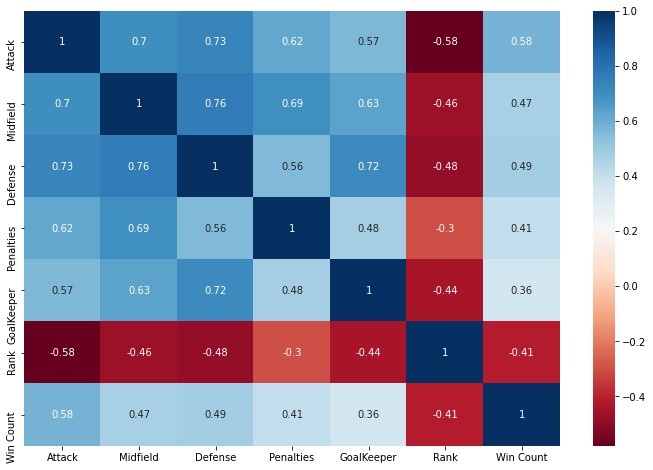

In [ ]:
corr=df_17_country.drop('Country',axis=1).astype('float').corr()

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr,annot=True,cmap='RdBu',ax=ax)

The correlation plot shows only a moderate correlation with a team's potential skill level and the number of wins as opposed to the strong correlated that would be expected. Some investingation revealed the possible reaons as
1. Qualification: Ideally if we can identify teams that can qualify for the match, we will get more accurate results. However as of now, the qualification for the 2022 world cup is not yet complete. Hence we have taken the top 50 teams. However, since qualification happens regionally and in groupes, a country that may not be very skilled still as the potential to get into the 32 teams that compete, and perhaps win a match or two depending on its group, whereas a stronger team that competes in a stronger region like in Europe may not qualify. 

2. Match structure: The selected 32 teams are grouped, and compete within the group to get into the top 16. The group a team falls into can make a different throughout the tournament, since if a team falls into a weaker group, and the adjacent groups are also weak, the team has a higher chance of winning matches compared to a team in a stronger group. However we do not have data on the match structure.

#### **Predicting Who will Qualify**

To remedy the problem of weaker teams qualifying while stronger teams do not, an attempt has been made to identify the teams that will likley qualify considering the quotas given to each confederation. 

Since having strong teams that dont win any matches simply because they did not qualify will skew the results, we have taken a stricter approach to identifying teams that will qualify. For each confederation we take the top performing teams upto the quoata for that confederations. Top performance has been by player skill level and by FIFA rank. Teams that appear to qualify as per both rank and player skill are deemed to have likely qualified.

In [ ]:
AFC=['Iran','Japan','Australia','Korea Republic']
CAF=['DR Congo','Senegal','Ecuador','Tunisia','Cameroon','Nigeria','Burkina Faso','Algeria','Ghana','Egypt']
CONCACAF=['Mexico','Costa Rica','United States']
CONMEBOL=['Brazil','Argentina','Chile','Colombia','Peru','Uruguay','Paraguay']
OFC=['New Zealand']
UEFA=['Germany','Switzerland','Poland','Portugal','Belgium','France','Spain','Italy','England','Croatia','Wales','Sweden','Iceland','Slovakia'
      'Northern Ireland','Ukraine','Republic of Ireland','Bosnia Herzegovina','Netherlands','Austria','Greece','Czech Republic','Serbia',
      'Romania','Denmark','Russia','Turkey']

In [ ]:
Quota={'AFC':5,'CAF':5,'CONCACAF':3,'CONMEBOL':5,'OFC':0,'UEFA':13}
# FIFA's initial decision was in decimal numbers, and the team that qualifies was decided based on a inter-confederation match. Here it 
# has been allocated to the confederation which was larger in size and had stronger teams.

In [ ]:
df_17_country['Confederation']='ABC'

for i in range(len(df_17_country)):
  df_17_country.loc[df_17_country['Country'].isin(AFC),'Confederation']='AFC'
  df_17_country.loc[df_17_country['Country'].isin(CAF),'Confederation']='CAF'
  df_17_country.loc[df_17_country['Country'].isin(CONCACAF),'Confederation']='CONCACAF'
  df_17_country.loc[df_17_country['Country'].isin(CONMEBOL),'Confederation']='CONMEBOL'
  df_17_country.loc[df_17_country['Country'].isin(OFC),'Confederation']='OFC'
  df_17_country.loc[df_17_country['Country'].isin(UEFA),'Confederation']='UEFA'

In [ ]:
df_17_country.sample(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Win Count,Confederation
50,Russia,78,80.3333,80,72.3333,78,62,2.0,UEFA
43,Japan,74.6667,79.3333,74.6667,71.1667,69.1667,44,1.0,AFC
32,Turkey,77.3333,81.3333,78.6667,77.6667,76.3333,33,0.0,UEFA
25,United States,76.3333,77.6667,77.3333,64.6667,72.3333,26,0.0,CONCACAF
47,Algeria,76.3333,82,76.6667,75.3333,66.5,48,0.0,CAF


In [ ]:
df_17_country['Average Score']=df_17_country[['Attack','Midfield','Defense','GoalKeeper']].mean(axis=1)

In [ ]:
df17_qual_score=pd.DataFrame(columns=df_17_country.columns)

for confederation in list(Quota.keys()):
  temp=df_17_country.loc[df_17_country['Confederation']==confederation]
  temp=temp.sort_values(by='Average Score',ascending=False)
  temp=temp.head(Quota[confederation])
  df17_qual_score=df17_qual_score.append(temp,ignore_index=True)

In [ ]:
df17_qual_score.tail(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Win Count,Confederation,Average Score
25,Croatia,81,86.6667,80.6667,77,72,16,4.0,UEFA,80.083333
26,Poland,82.6667,77.6667,83,70.6667,76.5,5,1.0,UEFA,79.958333
27,Russia,78,80.3333,80,72.3333,78,62,2.0,UEFA,79.083333
28,Switzerland,76,80.6667,80,66.5,78.6667,4,1.0,UEFA,78.833333
29,Denmark,77.6667,82.3333,79.6667,71,75,46,1.0,UEFA,78.666667


In [ ]:
df17_qual_rank=pd.DataFrame(columns=df_17_country.columns)

for confederation in list(Quota.keys()):
  temp=df_17_country.loc[df_17_country['Confederation']==confederation]
  temp=temp.sort_values(by='Rank',ascending=True)
  temp=temp.head(Quota[confederation])
  df17_qual_rank=df17_qual_rank.append(temp,ignore_index=True)

In [ ]:
df17_qual_rank.tail(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Win Count,Confederation,Average Score
25,England,83.6667,82.3333,83,69.8333,79.5,13,3.0,UEFA,82.125000
26,Croatia,81,86.6667,80.6667,77,72,16,4.0,UEFA,80.083333
27,Wales,78.6667,78,79,69,69.1667,18,0.0,UEFA,76.208333
28,Sweden,82.6667,78.3333,79.3333,71,73,19,3.0,UEFA,78.333333
29,Iceland,75,76.6667,70.6667,66.8333,63.6667,20,0.0,UEFA,71.500000


In [ ]:
countries_by_score=list(df17_qual_rank['Country'])
df_qual=df17_qual_score[df17_qual_score['Country'].isin(countries_by_score)].drop('Average Score',axis=1)

In [ ]:
df_qual.shape

(23, 9)

In [ ]:
df_qual.iloc[5:15]

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Win Count,Confederation
8,Ecuador,75.3333,77,75.6667,71.6667,70.6667,32,0.0,CAF
9,Mexico,80.6667,80,78.6667,71.8333,74.8333,14,2.0,CONCACAF
10,United States,76.3333,77.6667,77.3333,64.6667,72.3333,26,0.0,CONCACAF
11,Costa Rica,66.3333,75.6667,75.3333,65,77,21,0.0,CONCACAF
12,Argentina,87.3333,88.3333,83,76.8333,79.3333,3,1.0,CONMEBOL
13,Brazil,83.6667,85,87,67.3333,79.6667,1,3.0,CONMEBOL
15,Colombia,81,82.6667,78,75.6667,73.3333,8,2.0,CONMEBOL
16,Chile,81.6667,83,75.3333,74.3333,73.8333,7,0.0,CONMEBOL
17,Germany,83.3333,88.3333,87,70.1667,85.1667,2,1.0,UEFA
18,Spain,84.3333,87,87.3333,73.5,83.8333,11,1.0,UEFA


Of the sample of 10 countries, 3 dont qualify in reality (USA, Ecuador and Chile), while the other 7 do.

### **Final Model**

For the final model, we will initially build a classification model to predict whether a team wins 3 or more matches.Then that prediction will be included as a dummy variable into a regression model that will attempt to predict the number of wins a team will get.

##### **Standardizing the Variables**

In [ ]:
columns_norm=['Attack','Midfield','Defense','Penalties','GoalKeeper']
df_qual[columns_norm]=(df_qual[columns_norm]-df_qual[columns_norm].mean())/df_qual[columns_norm].std()

In [ ]:
df_qual.tail(5)

#### **Decision Tree**

A decision tree will be used to predict whether a country will get 3 or more wins in the FIFA tournament. Since our dataset is small, care has been to be taken to prevent overfitting. To achieve this we have limited maximum depth to 3 levels and minimum samples for a node to split to 5.

In [ ]:
conditions=[df_qual['Win Count']>=3,df_qual['Win Count']<3]
choices=[1,0]

df_qual['Win Category']=np.select(conditions,choices)

In [ ]:
X_train=df_qual[['Attack','Midfield','Defense','GoalKeeper','Rank']].round().head(24) #,'Penalties'
y_train=df_qual['Win Category'].head(24)
X_test=df_qual[['Attack','Midfield','Defense','GoalKeeper','Rank']].round().tail(3) #,'Penalties'
y_test=df_qual['Win Category'].tail(3)

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3,min_samples_split=5)
clf = clf.fit(X_train,y_train)


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [ ]:
pd.DataFrame({'Country':df_qual['Country'].tail(3),'Actual':list(y_test),'Predicted':list(y_pred)})

,Country,Actual,Predicted
25,Croatia,1,1
26,Poland,0,0
28,Switzerland,0,0


[Text(167.4, 181.2, 'X[0] <= 0.69\ngini = 0.34\nsamples = 23\nvalue = [18, 5]'),
 Text(83.7, 108.72, 'X[1] <= 0.902\ngini = 0.117\nsamples = 16\nvalue = [15, 1]'),
 Text(41.85, 36.23999999999998, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(251.10000000000002, 108.72, 'X[1] <= 1.04\ngini = 0.49\nsamples = 7\nvalue = [3, 4]'),
 Text(209.25, 36.23999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(292.95, 36.23999999999998, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]')]

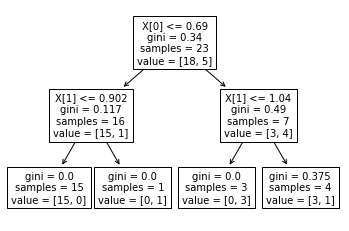

In [ ]:
tree.plot_tree(clf)

It is an anomally that the tree divides countries up such that when the attack score is greater than 0.72 and the midfielding score is *less* than 1.066, a team will win more than three matches. This kind of anomaly, where a lower performance results in a higher number of wins, exists regardless of whether the dividing number of wins is 2,3, or 4. It seems to indicate that teams that are very strong do not show the expected high number of wins.

In [ ]:
pd.DataFrame({'Field':X_train.columns,'Importance':list(clf.feature_importances_)})

,Field,Importance
0,Attack,0.398748
1,Midfield,0.601252
2,Defense,0.000000
3,GoalKeeper,0.000000
4,Rank,0.000000


In [ ]:
df_qual.loc[:,'More Than 3 Wins']=clf.predict(df_qual[['Attack','Midfield','Defense','GoalKeeper','Rank']])

#### **Regression Considering Qualification**

Here, we will include the previous models prediction as a dummy variable and attempt to predict the number of wins a team will get.

In [ ]:
df17_regression = df_qual[['Attack','Midfield','More Than 3 Wins','Win Count']].reset_index(drop=True)

In [ ]:
df17_train=df17_regression

y17_train =df17_train['Win Count']
X17_train =df17_train.drop('Win Count',axis=1)

X17_train.insert(0,'Ones',1)

In [ ]:
model=sm.OLS(y17_train.astype('float'),X17_train.astype('float')).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Win Count   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     7.254
Date:                Wed, 18 Aug 2021   Prob (F-statistic):            0.00195
Time:                        13:52:16   Log-Likelihood:                -36.614
No. Observations:                  23   AIC:                             81.23
Df Residuals:                      19   BIC:                             85.77
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Ones                 1.1020      0.304  

In [ ]:
pd.DataFrame({'Actual Wins':list(y17_train),'Predicted Wins':map(lambda x: round(x),list(model.predict(X17_train)))}).sample(3)

,Actual Wins,Predicted Wins
9,1.0,2
5,0.0,1
19,1.0,1


In [ ]:
df_final=df_qual
df_final.loc[:,'Predicted Wins']=list(map(lambda x: round(x),list(model.predict(sm.add_constant(df_final[['Attack','Midfield','More Than 3 Wins']])))))

In [ ]:
df_final.sort_values(by='Predicted Wins',ascending=False).head(3)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Win Count,Confederation,Win Category,More Than 3 Wins,Predicted Wins
25,Croatia,0.286283,1.04022,0.104483,1.25869,-0.694992,16,4.0,UEFA,1,1,4
22,England,0.783227,0.143892,0.565352,-0.261267,0.657107,13,3.0,UEFA,1,1,4
19,France,1.28017,0.97127,0.828705,1.43543,1.31813,10,6.0,UEFA,1,1,4


Note: The number of wins computed from the dataset is not an indicator how how far into the tournament a team reached. For example, Croatia won four matches, but advanced all the way into the finals,wheras Belgium that won 6 did not. This was because Croatia advance when it drew by scoring more penalty kicks.

### **Predicting for 2021**

Now the decision tree and the regression model will be applied to data as of 2021 to try to predict the teams that will likely win the highest number of matches in the 2022 World Cup.

In [ ]:
# None of the Qatar players have played in leagues. Therefore  a score for attack, defense, midfield and goalkeeping cannot be obtained. 
# Since defense and midfield are important for the classifier to work, the row will be removed  from dataset. It is unlikely that Qatar 
# will have the highest number of wins in the tournament even though they are the host, since most of the high performing teams have 
# players who are experienced in playing against a range of opponents in top clubs

df_21_country=df_21_country.dropna(how='all',subset=['Attack','Midfield','Defense','GoalKeeper'])

In [ ]:
Quota21={'AFC':5,'CAF':5,'CONCACAF':3,'CONMEBOL':5,'OFC':0,'UEFA':13}
# we have dropped the slot available for the host since the host is not included in the dataset

In [ ]:
df_21_country['Confederation']='ABC'

for i in range(len(df_21_country)):
  df_21_country.loc[df_21_country['Country'].isin(AFC),'Confederation']='AFC'
  df_21_country.loc[df_21_country['Country'].isin(CAF),'Confederation']='CAF'
  df_21_country.loc[df_21_country['Country'].isin(CONCACAF),'Confederation']='CONCACAF'
  df_21_country.loc[df_21_country['Country'].isin(CONMEBOL),'Confederation']='CONMEBOL'
  df_21_country.loc[df_21_country['Country'].isin(OFC),'Confederation']='OFC'
  df_21_country.loc[df_21_country['Country'].isin(UEFA),'Confederation']='UEFA'

In [ ]:
df_21_country.sample(3)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Confederation
10,Denmark,76,77.8333,79,63.4167,78.3333,11,UEFA
27,Tunisia,67.6667,72.8333,70.1667,65.6667,58,28,CAF
6,Spain,82.8333,85.5,85.8333,68.5833,84,7,UEFA


In [ ]:
df_21_country['Average Score']=df_21_country[['Attack','Midfield','Defense','GoalKeeper']].mean(axis=1)

In [ ]:
df21_qual_score=pd.DataFrame(columns=df_21_country.columns)

for confederation in list(Quota21.keys()):
  temp=df_21_country.loc[df_21_country['Confederation']==confederation]
  temp=temp.sort_values(by='Average Score',ascending=False)
  temp=temp.head(Quota21[confederation])
  df21_qual_score=df21_qual_score.append(temp,ignore_index=True)

df21_qual_rank=pd.DataFrame(columns=df_21_country.columns)

for confederation in list(Quota.keys()):
  temp=df_21_country.loc[df_21_country['Confederation']==confederation]
  temp=temp.sort_values(by='Rank',ascending=True)
  temp=temp.head(Quota21[confederation])
  df21_qual_rank=df21_qual_rank.append(temp,ignore_index=True)

countries_by_score21=list(df21_qual_rank['Country'])
df21_qual=df21_qual_score[df21_qual_score['Country'].isin(countries_by_score21)]

df21_qual.sample(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Confederation,Average Score
9,Mexico,77.6667,79.5,75.8333,71.5,77,9,CONCACAF,77.500000
3,Iran,72.1667,69.3333,70.6667,63,71.3333,26,AFC,70.875000
14,Uruguay,80.3333,80.6667,81.6667,69.6667,80.3333,13,CONMEBOL,80.750000
18,Spain,82.8333,85.5,85.8333,68.5833,84,7,UEFA,84.541667
20,England,83.1667,83.8333,83.8333,76.1667,81,4,UEFA,82.958333


In [ ]:
columns_norm=['Attack','Midfield','Defense','Penalties','GoalKeeper']
df21_qual[columns_norm]=(df21_qual[columns_norm]-df21_qual[columns_norm].mean())/df21_qual[columns_norm].std()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
df21_qual.loc[:,'More Than 3 Wins']=clf.predict(df21_qual[['Attack','Midfield','Defense','GoalKeeper','Rank']])
df21_qual.loc[:,'Predicted Wins']=list(model.predict(sm.add_constant(df21_qual[['Attack','Midfield','More Than 3 Wins']])))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


##### **Prediction**

In [ ]:
df21_qual.sort_values(by='Predicted Wins',ascending=False).head(7)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Confederation,Average Score,More Than 3 Wins,Predicted Wins
13,Argentina,1.64625,0.912096,0.489305,0.945799,0.605428,6,CONMEBOL,83.083333,1,4.304154
19,Germany,0.380614,1.42977,1.05599,0.301377,1.54037,16,UEFA,84.166667,1,4.176025
24,Netherlands,1.01343,0.946608,1.08933,1.16626,0.162561,12,UEFA,82.208333,1,4.152052
20,England,1.01343,0.946608,1.22267,1.55631,0.507013,4,UEFA,82.958333,1,4.152052
22,Portugal,0.869609,0.946608,0.822651,0.810131,0.654636,8,UEFA,82.500000,1,4.114405
21,Belgium,0.783316,0.98112,0.722647,1.47151,0.999088,1,UEFA,82.875000,1,4.105361
23,Italy,0.725787,0.532467,0.88932,1.18322,0.900673,5,UEFA,82.291667,1,3.914225


While, it is hard to predict one country as being the most successful ( in terms of number of wins) in 2022, according to the model, it is likely one of these seven countries.

In [ ]:
df21_qual.loc[df21_qual['Country']=='France']

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Confederation,Average Score,More Than 3 Wins,Predicted Wins
17,France,1.53119,1.08466,1.38934,1.13234,0.949881,3,UEFA,84.833333,0,1.928534


The common consensus is that France will win the World Cup again. The team's performance numbers also indicate that. However, based on our classification mode, extremely powerful teams do not perform as well as expected.It is quite commonly known in Football as the "Champion's Curse". Thus the model expects France to  perform quite poorly.

Further, though Germany has a high number of predicted wins, it is unlikly to happen reality since it has a relatively low attacking and penelty performance, and those are key skills to advance in the tournament.

## **b) If the 1st four opponents of England in the said world cup are Brazil, Uruguay,France and Germany define using the above ML algorithm what are the chances of England winning those matches.**

Ideally, we should be able to fit a Naive Bayes model to the results dataset. Then, given the two teams, we should be able to get the probability of a particular team winning. Even with the teams skill level changing over time, we should ideally be able to take a dataset of recent years and then pull out the probability. A complication to this is that, two of the teams are South American teams, which the team of England does not face often. Further, with COVID 19 the number of matches played have reduced as well. Thus it is hard to get an updated dataset of recently played matches. Hence we will again be using the EA sports dataset to try to achieve our results.

#### **Model Structure**

To predict the number of matches England will win given its opponents, we will try to predict the outcome of each match individually. To do this we need to train a model that, given the two teams of a match, will predict the outcome.

To do this, we will use the data in the results datasheet giving us the two teams and the number of goals scored by each team in the FIFA 2018 tournament. The filtering of the data has been done outside this code file, and the filtered dataset has been imported.

We will be adding variables represeing each teams skill level to the dataset and passing it through a random forest classifier to predict the winner of a match.

#### **Skill level of a country**

Obtaining the skill level of is done in the same way as for part (a). However since we would like information for the teams that qualified for FIFA but did not rank within the top 50 ( which is what we took for part a), we will reimport the raw data set, filter for the countries that qualified, and clean and restructure the dataset as in part a.

Including only the qualified countries should not be causing look ahead bias here since the purpose of this model is to predict the outcome of a match of the two teams are given. Who the teams are does not have to predicted.

In [ ]:
Qualified2018=['Australia','Iran','Japan','Saudi Arabia','Korea Republic','Egypt','Morocco','Nigeria','Senegal','Tunisia','Mexico','Costa Rica','Panama','Argentina',
               'Brazil','Colombia','Peru','Uruguay','Belgium','Croatia','Denmark','England','France','Germany','Iceland','Poland','Portugal','Russia',
               'Serbia','Spain','Sweden','Switzerland']

In [ ]:
df17_b=pd.read_csv('/wd/FIFA17_official_data.csv')
df17_b=df17_b.loc[df17_b['Nationality'].isin(Qualified2018)]

In [ ]:
def year_extract(x):
  if isinstance(x, list):
    if len(x)==0:
      return np.nan
    else:
      return x[0]
  else:
    return np.nan

df17_b['Contract Valid Until year']=df17_b['Contract Valid Until'].str.findall(r'[0-9]{4}').apply(lambda x:year_extract(x))
df17_b.loc[((df17_b['Contract Valid Until year'].isna())|(df17_b['Contract Valid Until year']=='2021'))& (df17_b['Age']<35),'Contract Valid Until year']='2017'
df17_b.loc[((df17_b['Contract Valid Until year'].isna())|(df17_b['Contract Valid Until year']=='2021'))& (df17_b['Age']>=35),'Contract Valid Until year']='2016'
df17_b['Contract Valid Until year']=df17_b['Contract Valid Until year'].astype('int')
df17_b=df17_b.loc[df17_b['Contract Valid Until year']>=2017]

In [ ]:
df17_b=df17_b[['Name','Nationality', 'Overall','Best Position','Penalties']]

In [ ]:
conditions_17=[df17_b['Best Position'].eq('LM')|df17_b['Best Position'].eq('RM')|df17_b['Best Position'].eq('CM')|df17_b['Best Position'].eq('CAM')|df17_b['Best Position'].eq('CDM'),
            df17_b['Best Position'].eq('CF')|df17_b['Best Position'].eq('RW')|df17_b['Best Position'].eq('LW')|df17_b['Best Position'].eq('ST'),
            df17_b['Best Position'].eq('CB')|df17_b['Best Position'].eq('RWB')|df17_b['Best Position'].eq('LWB')|df17_b['Best Position'].eq('RB')|df17_b['Best Position'].eq('LB'),
            df17_b['Best Position'].eq('GK')]

choices =['Midfield','Attack','Defense','GoalKeeper']

df17_b['Broad Position']=np.select(conditions_17,choices)

In [ ]:
df_17_country_b=pd.DataFrame(columns=['Country','Attack','Midfield','Defense','Penalties','GoalKeeper'])

areas =['Midfield','Attack','Defense','GoalKeeper']
for country in Qualified2018:
  country_df=df17_b.loc[df17_b['Nationality']==country]
  position_data={}
  position_data['Country']=country
  penalty_sum=0
  player_count=0
  for position in areas:
    position_df=country_df.loc[country_df['Broad Position']== position]
    position_df.sort_values(by='Overall',ascending=False,inplace=True)
    if position=='GoalKeeper':
      position_df=position_df.head(6)
    else:
      position_df=position_df.head(3) 
    if (position=='Attack')|(position=='Midfield'):
      penalty_sum+=position_df['Penalties'].sum()
      player_count+=position_df.shape[0]
    position_data[position]=position_df['Overall'].mean()
  position_data['Penalties']=penalty_sum/player_count
  df_17_country_b=df_17_country_b.append(position_data,ignore_index=True)

df_17_country_b=df_17_country_b.T.fillna(df_17_country_b.mean(axis=1)).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
columns_norm=['Attack','Midfield','Defense','Penalties','GoalKeeper']

df_17_country_b[columns_norm]=(df_17_country_b[columns_norm]-df_17_country_b[columns_norm].mean())/df_17_country_b[columns_norm].std()

In [ ]:
df_17_country_b.sample(5)

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper
20,Denmark,-0.0581746,0.491511,0.187875,0.179962,0.210732
8,Senegal,0.116349,0.360442,0.187875,0.0420271,-1.27641
31,Switzerland,-0.349047,0.163837,0.252174,-0.7511,0.774819
13,Argentina,1.62889,1.67114,0.830868,1.38689,0.877381
0,Australia,-1.27984,-1.08133,-0.905214,-0.958002,0.0312492


#### **Structing the Data Set**

The dataset we will be using will consist of the relative skill of a countries potential team compared to their opponent in the match. To do this, we will be including the attacking, defending, midfielding and goalkeeping of both the teams into the dataset. Then we will be computing the difference between the skills levels.

Accordingly the variables we will be using are:
- ATK_ATK: Attacking skill score of team A less the attacking skill score of team B
- ATK_MDF: Attacking skill score of team A less the midfielding skill score of team B
- ATK_DFS:Attacking skill score of team A less the defending skill score of team B
- ATK_GK:Attacking skill score of team A less the goalkeeping skill score of team B
- MDF_ATK:Midfielding skill score of team A less the attacking skill score of team B
- MDF_MDF:Midfielding skill score of team A less the midfielding skill score of team B
- MDF_DFS:Midfielding skill score of team A less the defending skill score of team B
- MDF_GK:Midfielding skill score of team A less the goalkeeping skill score of team B
- DFS_ATK:Defending skill score of team A less the attacking skill score of team B
- DFS_MDF:Defending skill score of team A less the midfielding skill score of team B
- GK_ATK:Goalkeeping skill score of team A less the attacking skill score of team B
- GK_MDF:Goalkeeping skill score of team A less the midfielding skill score of team B

The logic behind this scores are as follows:
- ATK_ATK: Influences possesion of the ball. The stronger attackers will likely have more possesion.
- ATK_MDF: Influences possesion of the ball and the ability of the attackers in team A to break through the defense of team B
- ATK_DFS: Represents the ability of the attackers in team A to break through the defense of team B
- ATK_GK: Represents the ability of the attackers in team A to get through the goalkeeper of team B
- MDF_ATK: Represents team A's ability to regain possesion of the ball from team B's attackers
- MDF_MDF: Midfielders may face each other when both attacking and defending.
- MDF_DFS: Midfielders may have to often assist and this involves getting through the opponents defense.
- MDF_GK: The ability of a midfielder to pass the goalkeeper and score.
- DFS_ATK: Represents the ability of team A to defend againt team B's attackers.
- DFS_MDF: Represents the ability of team A to defend againt team B's midfielders.
- GK_ATK: Represents the ability of the goalkeepers to stop goals from team B's attackers
- GK_MDF:Represents the ability of the goalkeepers to stop goals from team B's midfielders

In [ ]:
Goals18_df=pd.read_csv('/wd/FIFA18_MatchGoals.csv')
Goals18_df['Team A']=Goals18_df['Team A'].str.strip()
Goals18_df['Team B']=Goals18_df['Team B'].str.strip()
Goals18_df=Goals18_df.replace('South Korea','Korea Republic')
Goals18_df.sample()

,Team A,Team B,Goals A,Goals B
21,Nigeria,Iceland,2,0


In [ ]:
Goals18_df=pd.merge(Goals18_df,df_17_country_b[['Country','Attack','Midfield','Defense','Penalties','GoalKeeper']],how='left',left_on='Team A',right_on='Country').drop('Country',axis=1)
Goals18_df=pd.merge(Goals18_df,df_17_country_b[['Country','Attack','Midfield','Defense','Penalties','GoalKeeper']],how='left',left_on='Team B',right_on='Country',suffixes=(' A', ' B')).drop('Country',axis=1)

In [ ]:
Goals18_df.sample(5)

,Team A,Team B,Goals A,Goals B,Attack A,Midfield A,Defense A,Penalties A,GoalKeeper A,Attack B,Midfield B,Defense B,Penalties B,GoalKeeper B
45,Poland,Colombia,0,3,0.814444,-0.425977,0.830868,0.110995,0.441495,0.523571,0.557046,-0.133622,1.14551,-0.0456719
58,Russia,Croatia,2,2,-2.48013e-15,0.0983023,0.252174,0.455832,0.672258,0.523571,1.34346,0.380773,1.42138,-0.250795
4,Uruguay,Russia,3,0,1.22167,-0.360442,0.959467,0.697219,0.133811,-2.48013e-15,0.0983023,0.252174,0.455832,0.672258
2,Russia,Egypt,3,1,-2.48013e-15,0.0983023,0.252174,0.455832,0.672258,-0.174524,-1.01579,-1.35531,-0.889035,-0.404637
35,Mexico,Sweden,0,3,0.465396,0.0327674,-0.00502339,0.352381,0.185091,0.814444,-0.294907,0.123575,0.179962,-0.0969526


In [ ]:
Goals18_df['ATK_ATK']=Goals18_df['Attack A']-Goals18_df['Attack B']
Goals18_df['ATK_MDF']=Goals18_df['Attack A']-Goals18_df['Midfield B']
Goals18_df['ATK_DFS']=Goals18_df['Attack A']-Goals18_df['Defense B']
Goals18_df['ATK_GK']=Goals18_df['Attack A']-Goals18_df['GoalKeeper B']
Goals18_df['MDF_ATK']=Goals18_df['Midfield A']-Goals18_df['Attack B']
Goals18_df['MDF_MDF']=Goals18_df['Midfield A']-Goals18_df['Midfield B']
Goals18_df['MDF_DFS']=Goals18_df['Midfield A']-Goals18_df['Midfield B']
Goals18_df['MDF_GK']=Goals18_df['Midfield A']-Goals18_df['GoalKeeper B']
Goals18_df['DFS_ATK']=Goals18_df['Defense A']-Goals18_df['Attack B']
Goals18_df['DFS_MDF']=Goals18_df['Defense A']-Goals18_df['Midfield B']
Goals18_df['GK_ATK']=Goals18_df['GoalKeeper A']-Goals18_df['Attack B']
Goals18_df['GK_MDF']=Goals18_df['GoalKeeper A']-Goals18_df['Midfield B']

##### **Normalizing the variables**

In [ ]:
columns_norm=['ATK_ATK','ATK_MDF','ATK_DFS','ATK_GK','MDF_ATK','MDF_MDF','MDF_DFS','MDF_GK','DFS_ATK',
           'DFS_MDF','GK_ATK','GK_MDF']

Goals18_df[columns_norm]=(Goals18_df[columns_norm]-Goals18_df[columns_norm].mean())/Goals18_df[columns_norm].std()

##### **Computing the depeding the dependent variable**

- 2 : Team A wins
- 1 : Draw
- 0 : Team B wins

In [ ]:
Winning_Team=[]
for i in range(Goals18_df.shape[0]):
  row=Goals18_df.iloc[i]
  if (row['Goals A']>row['Goals B']):
    Winning_Team.append(2)
  elif (row['Goals A']<row['Goals B']):
    Winning_Team.append(0)
  else:
    Winning_Team.append(1)

Goals18_df['Winning Team']=Winning_Team
Goals18_df.sample(3)

,Team A,Team B,Goals A,Goals B,Attack A,Midfield A,Defense A,Penalties A,GoalKeeper A,Attack B,Midfield B,Defense B,Penalties B,GoalKeeper B,ATK_ATK,ATK_MDF,ATK_DFS,ATK_GK,MDF_ATK,MDF_MDF,MDF_DFS,MDF_GK,DFS_ATK,DFS_MDF,GK_ATK,GK_MDF,Winning Team
39,England,Panama,6,1,0.988968,0.491511,0.830868,-0.0614242,0.903021,-2.21063,-2.06435,-1.8697,-1.75113,-1.12257,2.13946,2.15465,1.92415,1.41007,1.68935,1.6771,1.6771,0.986512,1.88417,1.91065,2.01024,2.02791,2
40,England,Belgium,0,1,0.988968,0.491511,0.830868,-0.0614242,0.903021,0.930793,1.54007,1.15236,1.24896,0.749179,-0.163959,-0.605725,-0.354261,-0.0605928,-0.454115,-0.871862,-0.871862,-0.378543,-0.248522,-0.667688,-0.16436,-0.582925,0
6,Morocco,Iran,0,1,-0.698095,0.0983023,-0.0693227,1.31793,-0.327716,-0.756269,-1.67114,-1.77326,-2.2339,-1.40461,-0.163959,0.561512,0.579518,0.306123,0.428709,1.12097,1.12097,0.90544,0.285679,0.985449,0.151524,0.851614,0


##### **Preparing the training and test data**

A random sample of 10 matches are set aside for testing. 

In [ ]:
test=np.random.randint(0,Goals18_df.shape[0],size=10)

In [ ]:
test_data_b=Goals18_df.iloc[test]
Goals18_df=Goals18_df.drop(test)

In [ ]:
Goals18_df=Goals18_df.reset_index(drop=True)

X_columns=columns_norm=['ATK_ATK','ATK_MDF','ATK_DFS','ATK_GK','MDF_ATK','MDF_MDF','MDF_DFS','MDF_GK','DFS_ATK','DFS_MDF','GK_ATK','GK_MDF']

X_train_b=Goals18_df[X_columns]
y_train_b=Goals18_df[['Winning Team']]

## **Random Forest Classifier**

Though random forests are typically data hungry, we have opted for the random forest for a number of reasons.

1. Tree based models can capture non linear relationships that regression models cannot capture.
2. The random forest considers a large number of trees each with a different set of feature variables. Thus the results will be more robust that just a decision tree.

Again, to prevent overfitting, we have limited the depth and minimum number of samples in a leaf. We have also used bootstrap since the dataset is small.

In [ ]:
clf=RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf=3,bootstrap=True)
clf = clf.fit(X_train_b,y_train_b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
pd.DataFrame({'Field':X_train_b.columns,'Importance':list(clf.feature_importances_)}).sort_values(by='Importance',ascending=False)

,Field,Importance
10,GK_ATK,0.150375
1,ATK_MDF,0.109395
4,MDF_ATK,0.102597
11,GK_MDF,0.095584
0,ATK_ATK,0.093773
2,ATK_DFS,0.086970
9,DFS_MDF,0.075686
5,MDF_MDF,0.074605
6,MDF_DFS,0.064060
8,DFS_ATK,0.062281


The face off between the attacker of one team and the goalkeeper of the other team and the face off between the attackers on one team and the midfielders of the other team seem to be key variables.

##### **Testing the model**

In [ ]:
test_data_b.sample()

,Team A,Team B,Goals A,Goals B,Attack A,Midfield A,Defense A,Penalties A,GoalKeeper A,Attack B,Midfield B,Defense B,Penalties B,GoalKeeper B,ATK_ATK,ATK_MDF,ATK_DFS,ATK_GK,MDF_ATK,MDF_MDF,MDF_DFS,MDF_GK,DFS_ATK,DFS_MDF,GK_ATK,GK_MDF,Winning Team
3,Uruguay,Saudi Arabia,1,0,1.22167,-0.360442,0.959467,0.697219,0.133811,-1.33801,-1.21239,-0.969514,0.386865,-0.737961,1.67024,1.6804,1.42091,1.29072,0.512636,0.472138,0.472138,0.084696,1.37906,1.39322,0.873712,0.853629,2


In [ ]:
X_columns=columns_norm=['ATK_ATK','ATK_MDF','ATK_DFS','ATK_GK','MDF_ATK','MDF_MDF','MDF_DFS','MDF_GK','DFS_ATK','DFS_MDF','GK_ATK','GK_MDF']
test_data_b['Predicted Winner']=clf.predict(test_data_b[X_columns])

In [ ]:
Winning_Team=[]
for i in range(test_data_b.shape[0]):
  row=test_data_b.iloc[i]
  if (row['Winning Team']==2):
    Winning_Team.append(row['Team A'])
  elif (row['Winning Team']==0):
    Winning_Team.append(row['Team B'])
  else:
    Winning_Team.append('Draw')

Predicted_Winner=[]
for i in range(test_data_b.shape[0]):
  row=test_data_b.iloc[i]
  if (row['Predicted Winner']==2):
    Predicted_Winner.append(row['Team A'])
  elif (row['Predicted Winner']==0):
    Predicted_Winner.append(row['Team B'])
  else:
    Predicted_Winner.append('Draw')


test_data_b['Winning Team']=Winning_Team
test_data_b['Predicted Winner']=Predicted_Winner


In [ ]:
test_data_b[['Team A','Team B','Goals A','Goals B','Winning Team','Predicted Winner']]

,Team A,Team B,Goals A,Goals B,Winning Team,Predicted Winner
3,Uruguay,Saudi Arabia,1,0,Uruguay,Uruguay
24,Costa Rica,Serbia,0,1,Serbia,Serbia
45,Poland,Colombia,0,3,Colombia,Colombia
12,France,Australia,2,1,France,France
32,Korea Republic,Mexico,1,2,Mexico,Mexico
50,Brazil,Mexico,2,0,Brazil,Brazil
38,Belgium,Tunisia,5,2,Belgium,Belgium
46,Japan,Poland,0,1,Poland,Poland
49,France,Argentina,4,3,France,Argentina
48,Uruguay,Portugal,2,1,Uruguay,Portugal


In [ ]:
conditions=[test_data_b['Predicted Winner']==test_data_b['Winning Team'],test_data_b['Predicted Winner']!=test_data_b['Winning Team']]
choice=[1,0]

test_data_b['Correct Prediction']=np.select(conditions,choice)

In [ ]:
accuracy=test_data_b['Correct Prediction'].sum()/test_data_b.shape[0]*100

print('The combined model has predicted %d %% of the match results correctly' %accuracy)

The combined model has predicted 80 % of the match results correctly


Since there are three outcomes, Team A, Team B and Draw, and a random choice would result in us getting the correct answer 33% of the time, the model is better than random prediction.


#### **Predicting for England in 2022**

In [ ]:
df22_b=pd.DataFrame({'Team A':['England','England','England','England'],'Team B':['Brazil','Uruguay','France','Germany']})

In [ ]:
Group=['England','Brazil','Uruguay','France','Germany']

In [ ]:
df_21_country_b=df_21_country
df_21_country.head()

,Country,Attack,Midfield,Defense,Penalties,GoalKeeper,Rank,Confederation,Average Score
0,Belgium,1.23672,1.3865,1.11252,1.95426,1.39919,1,UEFA,82.875000
1,Brazil,1.69493,1.65338,1.73067,1.6654,1.80132,2,CONMEBOL,85.000000
2,France,2.08769,1.50088,1.88521,1.56912,1.34174,3,UEFA,84.833333
3,England,1.49856,1.34838,1.69204,2.05055,0.824711,4,UEFA,82.958333
4,Italy,1.17126,0.89088,1.30569,1.62689,1.28429,5,UEFA,82.291667


In [ ]:
columns_norm=['Attack','Midfield','Defense','Penalties','GoalKeeper']

df_21_country_b[columns_norm]=(df_21_country_b[columns_norm]-df_21_country_b[columns_norm].mean())/df_21_country_b[columns_norm].std()

In [ ]:
df22_b=pd.merge(df22_b,df_21_country_b[['Country','Attack','Midfield','Defense','Penalties','GoalKeeper']],how='left',left_on='Team A',right_on='Country').drop('Country',axis=1)
df22_b=pd.merge(df22_b,df_21_country_b[['Country','Attack','Midfield','Defense','Penalties','GoalKeeper']],how='left',left_on='Team B',right_on='Country',suffixes=(' A', ' B')).drop('Country',axis=1)

In [ ]:
df22_b['ATK_ATK']=df22_b['Attack A']-df22_b['Attack B']
df22_b['ATK_MDF']=df22_b['Attack A']-df22_b['Midfield B']
df22_b['ATK_DFS']=df22_b['Attack A']-df22_b['Defense B']
df22_b['ATK_GK']=df22_b['Attack A']-df22_b['GoalKeeper B']
df22_b['MDF_ATK']=df22_b['Midfield A']-df22_b['Attack B']
df22_b['MDF_MDF']=df22_b['Midfield A']-df22_b['Midfield B']
df22_b['MDF_DFS']=df22_b['Midfield A']-df22_b['Midfield B']
df22_b['MDF_GK']=df22_b['Midfield A']-df22_b['GoalKeeper B']
df22_b['DFS_ATK']=df22_b['Defense A']-df22_b['Attack B']
df22_b['DFS_MDF']=df22_b['Defense A']-df22_b['Midfield B']
df22_b['GK_ATK']=df22_b['GoalKeeper A']-df22_b['Attack B']
df22_b['GK_MDF']=df22_b['GoalKeeper A']-df22_b['Midfield B']


In [ ]:
columns_norm=['ATK_ATK','ATK_MDF','ATK_DFS','ATK_GK','MDF_ATK','MDF_MDF','MDF_DFS','MDF_GK','DFS_ATK',
           'DFS_MDF','GK_ATK','GK_MDF']

df22_b[columns_norm]=(df22_b[columns_norm]-df22_b[columns_norm].mean())/df22_b[columns_norm].std()

In [ ]:
X_columns=['ATK_ATK','ATK_MDF','ATK_DFS','ATK_GK','MDF_ATK','MDF_MDF','MDF_DFS','MDF_GK','DFS_ATK',
           'DFS_MDF','GK_ATK','GK_MDF']
df22_b['Predicted Winner']=clf.predict(df22_b[X_columns])

In [ ]:
df22_b

,Team A,Team B,Attack A,Midfield A,Defense A,Penalties A,GoalKeeper A,Attack B,Midfield B,Defense B,Penalties B,GoalKeeper B,ATK_ATK,ATK_MDF,ATK_DFS,ATK_GK,MDF_ATK,MDF_MDF,MDF_DFS,MDF_GK,DFS_ATK,DFS_MDF,GK_ATK,GK_MDF,Predicted Winner
0,England,Brazil,1.49856,1.34838,1.69204,2.05055,0.824711,1.69493,1.65338,1.73067,1.6654,1.80132,-0.514645,-0.433099,-0.510754,-0.566794,-0.514645,-0.433099,-0.433099,-0.566794,-0.514645,-0.433099,-0.514645,-0.433099,0
1,England,Uruguay,1.49856,1.34838,1.69204,2.05055,0.824711,0.94215,0.624005,1.18979,0.548479,0.709816,0.699389,1.43789,1.27688,1.30609,0.699389,1.43789,1.43789,1.30609,0.699389,1.43789,0.699389,1.43789,2
2,England,France,1.49856,1.34838,1.69204,2.05055,0.824711,2.08769,1.50088,1.88521,1.56912,1.34174,-1.14805,-0.155916,-1.02151,0.221789,-1.14805,-0.155916,-0.155916,0.221789,-1.14805,-0.155916,-1.14805,-0.155916,0
3,England,Germany,1.49856,1.34838,1.69204,2.05055,0.824711,0.778501,1.88213,1.49886,0.625508,2.03111,0.96331,-0.848875,0.255377,-0.961085,0.96331,-0.848875,-0.848875,-0.961085,0.96331,-0.848875,0.96331,-0.848875,1


In [ ]:
Predicted_Winner=[]
for i in range(df22_b.shape[0]):
  row=df22_b.iloc[i]
  if (row['Predicted Winner']==2):
    Predicted_Winner.append(row['Team A'])
  elif (row['Predicted Winner']==0):
    Predicted_Winner.append(row['Team B'])
  else:
    Predicted_Winner.append('Draw')

df22_b['Predicted Winner']=Predicted_Winner

In [ ]:
df22_b[['Team A','Team B','Predicted Winner']]

,Team A,Team B,Predicted Winner
0,England,Brazil,Brazil
1,England,Uruguay,England
2,England,France,France
3,England,Germany,Draw


##### **Prediction**

The model predicts that England will win againt Uruguay, draw against Germany and lose to Brazil and France.